# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset/Warning_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 550: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

18 2386
19 527
20 677
21 971
22 383
23 503
24 263
25 1997
26 593
27 1277
28 1001
29 263
30 443
31 773
48 209
49 281
50 245
51 209
52 353
53 245
54 209
55 245
56 173
57 173
58 173
59 209
60 569
61 173
62 173
63 173
64 209
65 281
66 173
67 173
68 209
69 209
70 173
71 173
all 17469


In [4]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    38
dtype: int64
18    2386
25    1997
27    1277
28    1001
21     971
31     773
20     677
26     593
60     569
19     527
23     503
30     443
22     383
52     353
65     281
49     281
24     263
29     263
55     245
53     245
50     245
54     209
48     209
69     209
68     209
59     209
51     209
64     209
70     173
67     173
66     173
63     173
62     173
61     173
58     173
57     173
56     173
71     173
Name: labels, dtype: int64


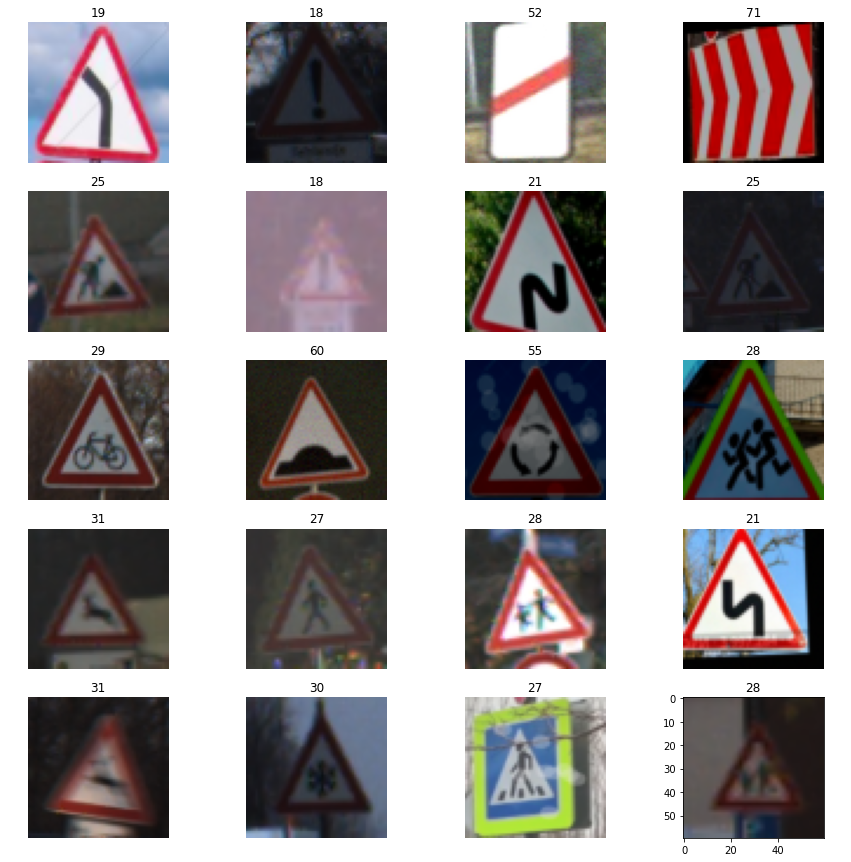

In [5]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

# opt = SGD(learning_rate=0.008)
opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

In [8]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
1223/1223 [==============================] - 20s 14ms/step - loss: 2.6952 - f1_score: 0.0876 - val_loss: 1.8007 - val_f1_score: 0.2017
Epoch 2/50
1223/1223 [==============================] - 17s 14ms/step - loss: 1.4340 - f1_score: 0.4061 - val_loss: 0.8485 - val_f1_score: 0.6386
Epoch 3/50
1223/1223 [==============================] - 16s 13ms/step - loss: 0.7641 - f1_score: 0.7058 - val_loss: 0.4469 - val_f1_score: 0.8454
Epoch 4/50
1223/1223 [==============================] - 16s 13ms/step - loss: 0.4737 - f1_score: 0.8387 - val_loss: 0.2478 - val_f1_score: 0.9331
Epoch 5/50
1223/1223 [==============================] - 16s 13ms/step - loss: 0.3373 - f1_score: 0.8909 - val_loss: 0.1915 - val_f1_score: 0.9439
Epoch 6/50
1223/1223 [==============================] - 16s 13ms/step - loss: 0.2432 - f1_score: 0.9194 - val_loss: 0.1244 - val_f1_score: 0.9549
Epoch 7/50
1223/1223 [==============================] - 16s 13ms/step - loss: 0.1967 - f1_score: 0.9356 - val_loss: 0.0945 -

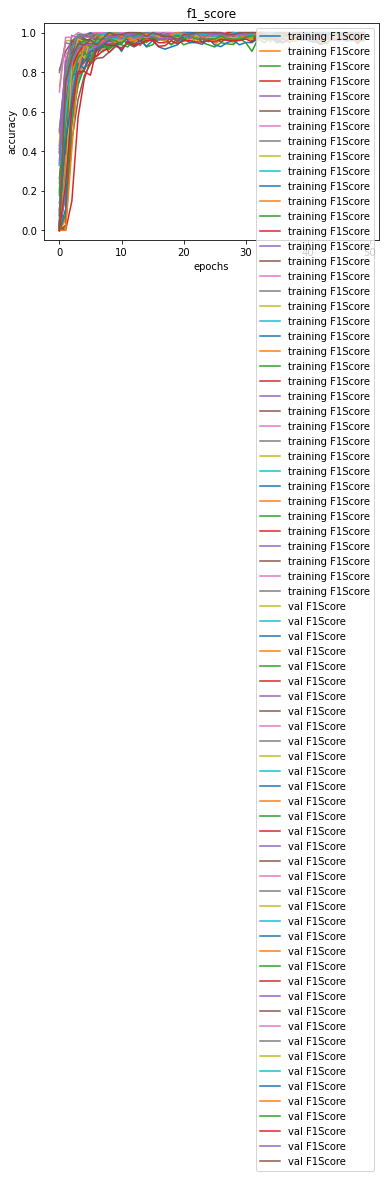

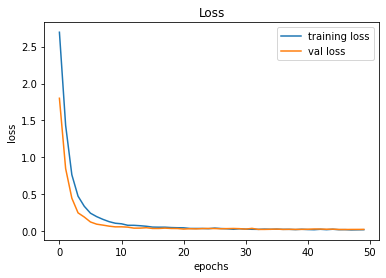

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
# model.save('./saved_models/Trafic_Signs_CNN_Warning_signs.h5')

In [12]:
Warning_signs_classes = {'0':18,
'1':19,
'2':20,
'3':21,
'4':22,
'5':23,
'6':24,
'7':25,
'8':26,
'9':27,
'10':28,
'11':29,
'12':30,
'13':31,
'14':48,
'15':49,
'16':50,
'17':51,
'18':52,
'19':53,
'20':54,
'21':55,
'22':56,
'23':57,
'24':58,
'25':59,
'26':60,
'27':61,
'28':62,
'29':63,
'30':64,
'31':65,
'32':66,
'33':67,
'34':68,
'35':69,
'36':70,
'37':71,}

In [19]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []

for c in range (18,32):
    try:
        for i in range(60):

            all_classes.append(c)
            # Считываем тестовый датасет
            image_path = df.loc[df['ClassId'] == c].values[i][1]
            classid = df.loc[df['ClassId'] == c].values[i][0]

            # Обрабатываем изображения
            image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
            image_resized = transform.resize(image, input_size)
            img_batch = np.expand_dims(image_resized,0)

            # Начинаем предсказание категории знака
            prediction = model.predict(img_batch)
            prediction = np.argmax(prediction, axis=1)
            predicted_classes.append(Warning_signs_classes[str(prediction[0])])

            if classid != Warning_signs_classes[(str(prediction[0]))]:
                 print(classid,Warning_signs_classes[(str(prediction[0]))], prediction[0], image_path)
    except:
        pass


1/1 [==============================] - 0s 17ms/step
18 65 31 Test/02342.png
1/1 [==============================] - 0s 17ms/step
18 21 3 Test/03739.png
1/1 [==============================] - 0s 16ms/step
18 25 7 Test/09242.png
1/1 [==============================] - 0s 28ms/step
18 21 3 Test/00198.png
1/1 [==============================] - 0s 17ms/step
18 19 1 Test/09073.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
21 64 30 Test/10398.png
1/1 [==============================] - 0s 17ms/step
21 64 30 Test/02370.png
1/1 [==============================] - 0s 27ms/step
21 19 1 Test/04400.png
1/1 [==============================] - 0s 16ms/step
21 64 30 Test/04185.png
1/1 [==============================] - 0s 18ms/step
21 31 13 Test/01865.png
1/1 [==============================] - 0s 17ms/step
21 64 30 Test/09835.png
1/1 [==============================] - 0s 18ms/step
21 19 1 Test/11393.png
1/1 [==============================] - 0s 16ms/step
21 64 30 Test/09792.png
1/1 [==============================] - 0s 17ms/step
21 64 30 Test/12111.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/00033.png
1/1 [==============================] - 0s 16ms/step
23 19 1 Test/00012.png
1/1 [==============================] - 0s 16ms/step
23 19 1 Test/07995.png


1/1 [==============================] - 0s 17ms/step
23 19 1 Test/05629.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/09434.png
1/1 [==============================] - 0s 18ms/step
23 19 1 Test/02954.png
1/1 [==============================] - 0s 29ms/step
23 19 1 Test/05093.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/05464.png
1/1 [==============================] - 0s 16ms/step
23 19 1 Test/05289.png
1/1 [==============================] - 0s 16ms/step
23 19 1 Test/09688.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/09213.png
1/1 [==============================] - 0s 19ms/step
23 19 1 Test/04786.png
1/1 [==============================] - 0s 16ms/step
23 19 1 Test/07568.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/02846.png
1/1 [==============================] - 0s 17ms/step
23 19 1 Test/06913.png
1/1 [==============================] - 0s 17ms/step
24 18 0 Test/11647.png
1/1 [====================

1/1 [==============================] - 0s 17ms/step
26 19 1 Test/04634.png
1/1 [==============================] - 0s 16ms/step
26 20 2 Test/06731.png
1/1 [==============================] - 0s 17ms/step
26 19 1 Test/08702.png
1/1 [==============================] - 0s 16ms/step
26 19 1 Test/12024.png
1/1 [==============================] - 0s 18ms/step
26 20 2 Test/11625.png
1/1 [==============================] - 0s 17ms/step
26 19 1 Test/08587.png
1/1 [==============================] - 0s 17ms/step
26 18 0 Test/06200.png
1/1 [==============================] - 0s 16ms/step
26 20 2 Test/12354.png
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 36ms/step
28 29 11 Test/11656.png
1/1 [==============================] - 0s 23ms/step
30 20 2 Test/02864.png
1/1 [==============================] - 0s 31ms/step
30 20 2 Test/00237.png
1/1 [==============================] - 0s 19ms/step
30 20 2 Test/04383.png
1/1 [==============================] - 0s 17ms/step
30 20 2 Test/07693.png
1/1 [==============================] - 0s 29ms/step
30 20 2 Test/11435.png
1/1 [==============================] - 0s 19ms/step
30 23 5 Test/04011.png
1/1 [==============================] - 0s 17ms/step
30 19 1 Test/00114.png
1/1 [==============================] - 0s 17ms/step
30 48 14 Test/00443.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
30 23 5 Test/08510.png
1/1 [==============================] - 0s 16ms/step
30 19 1 Test/01422.png
1/1 [==============================] - 0s 18ms/step
30 20 2 Test/03778.png
1/1 [==============================] - 0s 18ms/step
30 18 0 Test/09411.png
1/1 [==============================] - 0s 20ms/step
31 20 2 Test/07597.png
1/1 [==============================] - 0s 16ms/step
31 18 0 Test/12215.png
1/1 [==============================] - 0s 17ms/step


In [22]:
for c in range (48,72):
    for i in range(100):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(Warning_signs_classes[str(prediction[0])])
        
        if classid != Warning_signs_classes[(str(prediction[0]))]:
             print(classid,Warning_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
48 21 3 Test/48_4_0.png
1/1 [==============================] - 0s 14ms/step
48 61 27 Test/48_3_16.png
1/1 [==============================] - 0s 17ms/step
48 18 0 Test/48_3_28.png
1/1 [==============================] - 0s 16ms/step
48 56 22 Test/48_4_4.png
1/1 [==============================] - 0s 19ms/step
48 18 0 Test/48_7_38.png
1/1 [==============================] - 0s 19ms/step
48 61 27 Test/48_2_20.png
1/1 [==============================] - 0s 17ms/step
48 25 7 Test/48_4_6.png
1/1 [==============================] - 0s 18ms/step
48 18 0 Test/48_4_19.png
1/1 [==============================] - 0s 25ms/step
48 19 1 Test/48_4_21.png
1/1 [==============================] - 0s 18ms/step
48 64 30 Test/48_4_12.png
1/1 [==============================] - 0s 5ms/step
48 19 1 Test/48_4_29.png
1/1 [==============================] - 0s 17ms/step
48 64 30 Test/48_3_1_19.png
1/1 [==============================] - 0s 16ms/step
48 53 19 Test/48_6_6.

1/1 [==============================] - 0s 17ms/step
49 25 7 Test/49_6_4.png
1/1 [==============================] - 0s 6ms/step
49 52 18 Test/49_6_1.png
1/1 [==============================] - 0s 17ms/step
49 56 22 Test/49_1_26.png
1/1 [==============================] - 0s 20ms/step
50 52 18 Test/50_7_19.png
1/1 [==============================] - 0s 15ms/step
50 52 18 Test/50_1_17.png
1/1 [==============================] - 0s 17ms/step
50 52 18 Test/50_7_14.png
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step
51 70 36 Test/51_2_1.png
1/1 [==============================] - 0s 8ms/step
51 50 16 Test/51_2_9.png
1/1 [==============================] - 0s 17ms/step
51 20 2 Test/51_2_29.png
1/1 [==============================] - 0s 9ms/step
51 50 16 Test/51_3_16.png
1/1 [==============================] - 0s 16ms/step
51 50 16 Test/51_7_24.png
1/1 [==============================] - 0s 16ms/step
51 52 18 Test/51_7_12.png
1/1 [==============================] - 0s 16ms/step
51 52 18 Test/51_2_19.png
1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 11ms/step
53 69 35 Test/53_4_30.png
1/1 [==============================] - 0s 18ms/step
53 65 31 Test/53_4_9.png
1/1 [==============================] - 0s 23ms/step
53 22 4 Test/53_5_27.png
1/1 [==============================] - 0s 17ms/step
53 69 35 Test/53_4_17.png
1/1 [==============================] - 0s 16ms/step
53 69 35 Test/53_4_16.png
1/1 [==============================] - 0s 17ms/step
53 22 4 Test/53_5_28.png
1/1 [==============================] - 0s 27ms/step
53 22 4 Test/53_5_12.png
1/1 [==============================] - 0s 29ms/step
53 25 7 Test/53_4_29.png
1/1 [==============================] - 0s 17ms/step
53 22 4 Test/53_5_17.png
1/1 [==============================] - 0s 19ms/step
53 57 23 Test/53_5_10.png
1/1 [==============================] - 0s 38ms/step
53 68 34 Test/53_4_21.png
1/1 [==============================] - 0s 27ms/step
53 57 23 Test/53_5_9.png
1/1 [==============================] - 0s 18ms/step
53 25 7 Test/53_4_3

1/1 [==============================] - 0s 17ms/step
54 62 28 Test/54_5_22.png
1/1 [==============================] - 0s 16ms/step
54 66 32 Test/54_2_21.png
1/1 [==============================] - 0s 16ms/step
54 62 28 Test/54_5_0.png
1/1 [==============================] - 0s 18ms/step
55 70 36 Test/55_6_10.png
1/1 [==============================] - 0s 16ms/step
55 25 7 Test/55_4_14.png
1/1 [==============================] - 0s 5ms/step
55 70 36 Test/55_6_27.png
1/1 [==============================] - 0s 31ms/step
55 70 36 Test/55_4_28.png
1/1 [==============================] - 0s 13ms/step
55 52 18 Test/55_6_18.png
1/1 [==============================] - 0s 8ms/step
55 52 18 Test/55_5_11.png
1/1 [==============================] - 0s 11ms/step
55 52 18 Test/55_3_12.png
1/1 [==============================] - 0s 6ms/step
55 52 18 Test/55_3_18.png
1/1 [==============================] - 0s 16ms/step
55 70 36 Test/55_4_38.png
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 17ms/step
55 68 34 Test/55_2_19.png
1/1 [==============================] - 0s 12ms/step
55 70 36 Test/55_3_13.png
1/1 [==============================] - 0s 13ms/step
55 70 36 Test/55_3_11.png
1/1 [==============================] - 0s 8ms/step
55 70 36 Test/55_6_30.png
1/1 [==============================] - 0s 19ms/step
56 18 0 Test/56_2_24.png
1/1 [==============================] - 0s 20ms/step
56 21 3 Test/56_1_24.png
1/1 [==============================] - 0s 16ms/step
56 68 34 Test/56_4_4.png
1/1 [==============================] - 0s 16ms/step
56 20 2 Test/56_6_28.png
1/1 [==============================] - 0s 16ms/step
56 49 15 Test/56_6_26.png
1/1 [==============================] - 0s 17ms/step
56 20 2 Test/56_5_13.png
1/1 [==============================] - 0s 16ms/step
56 55 21 Test/56_2_17.png
1/1 [==============================] - 0s 28ms/step
56 20 2 Test/56_2_16.png
1/1 [==============================] - 0s 17ms/step
56 20 2 Test/56_2_2

1/1 [==============================] - 0s 16ms/step
57 63 29 Test/57_3_18.png
1/1 [==============================] - 0s 16ms/step
57 66 32 Test/57_3_29.png
1/1 [==============================] - 0s 16ms/step
57 18 0 Test/57_4_32.png
1/1 [==============================] - 0s 11ms/step
57 54 20 Test/57_5_2.png
1/1 [==============================] - 0s 16ms/step
57 19 1 Test/57_1_13.png
1/1 [==============================] - 0s 16ms/step
57 66 32 Test/57_3_25.png
1/1 [==============================] - 0s 16ms/step
57 66 32 Test/57_4_33.png
1/1 [==============================] - 0s 10ms/step
57 66 32 Test/57_2_16.png
1/1 [==============================] - 0s 28ms/step
57 66 32 Test/57_7_9.png
1/1 [==============================] - 0s 19ms/step
57 66 32 Test/57_4_22.png
1/1 [==============================] - 0s 17ms/step
57 54 20 Test/57_7_21.png
1/1 [==============================] - 0s 18ms/step
57 18 0 Test/57_6_21.png
1/1 [==============================] - 0s 18ms/step
57 20 2 Test/57_6

1/1 [==============================] - 0s 6ms/step
58 25 7 Test/58_3_29.png
1/1 [==============================] - 0s 8ms/step
58 61 27 Test/58_2_25.png
1/1 [==============================] - 0s 1ms/step
58 57 23 Test/58_7_36.png
1/1 [==============================] - 0s 5ms/step
58 61 27 Test/58_2_19.png
1/1 [==============================] - 0s 16ms/step
58 57 23 Test/58_7_5.png
1/1 [==============================] - 0s 1ms/step
58 48 14 Test/58_6_11.png
1/1 [==============================] - 0s 19ms/step
58 57 23 Test/58_7_25.png
1/1 [==============================] - 0s 16ms/step
58 59 25 Test/58_6_0.png
1/1 [==============================] - 0s 17ms/step
59 53 19 Test/59_4_13.png
1/1 [==============================] - 0s 18ms/step
59 65 31 Test/59_3_34.png
1/1 [==============================] - 0s 17ms/step
59 65 31 Test/59_7_16.png
1/1 [==============================] - 0s 16ms/step
59 25 7 Test/59_3_25.png
1/1 [==============================] - 0s 2ms/step
59 65 31 Test/59_1_20.

1/1 [==============================] - 0s 6ms/step
59 65 31 Test/59_7_29.png
1/1 [==============================] - 0s 17ms/step
60 22 4 Test/60_5_26.png
1/1 [==============================] - 0s 17ms/step
60 22 4 Test/60_7_32.png
1/1 [==============================] - 0s 17ms/step
60 68 34 Test/60_2_33.png
1/1 [==============================] - 0s 14ms/step
60 70 36 Test/60_7_22.png
1/1 [==============================] - 0s 16ms/step
60 55 21 Test/60_2_14.png
1/1 [==============================] - 0s 17ms/step
60 18 0 Test/60_5_22.png
1/1 [==============================] - 0s 16ms/step
60 58 24 Test/60_1_9.png
1/1 [==============================] - 0s 17ms/step
60 68 34 Test/60_1_34.png
1/1 [==============================] - 0s 18ms/step
60 22 4 Test/60_5_20.png
1/1 [==============================] - 0s 16ms/step
60 27 9 Test/60_4_25.png
1/1 [==============================] - 0s 18ms/step
60 18 0 Test/60_5_32.png
1/1 [==============================] - 0s 17ms/step
60 65 31 Test/60_1_2

1/1 [==============================] - 0s 16ms/step
61 28 10 Test/61_3_1.png
1/1 [==============================] - 0s 17ms/step
61 25 7 Test/61_7_22.png
1/1 [==============================] - 0s 17ms/step
62 53 19 Test/62_5_26.png
1/1 [==============================] - 0s 16ms/step
62 55 21 Test/62_4_30.png
1/1 [==============================] - 0s 16ms/step
62 64 30 Test/62_5_21.png
1/1 [==============================] - 0s 17ms/step
62 54 20 Test/62_4_16.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
62 49 15 Test/62_5_2.png
1/1 [==============================] - 0s 32ms/step
63 54 20 Test/63_2_6.png
1/1 [==============================] - 0s 17ms/step
63 20 2 Test/63_5_20.png
1/1 [==============================] - 0s 10ms/step
63 20 2 Test/63_5_27.png
1/1 [==============================] - 0s 19ms/step
63 55 21 Test/63_5_17.png
1/1 [==============================] - 0s 17ms/step
63 21 3 Test/63_3_9.png
1/1 [==============================] - 0s 16ms/step
63 21 3 Test/63_2_1.png
1/1 [==============================] - 0s 18ms/step
63 52 18 Test/63_5_22.png
1/1 [==============================] - 0s 17ms/step
63 21 3 Test/63_1_19.png
1/1 [==============================] - 0s 17ms/step
63 51 17 Test/63_2_20.png
1/1 [==============================] - 0s 17ms/step
63 21 3 Test/63_1_16.png
1/1 [==============================] - 0s 26ms/step
64 28 10 Test/64_7_2.png
1/1 [==============================] - 0s 20ms/step
64 62 28 Test/64_7_8.pn

1/1 [==============================] - 0s 29ms/step
64 28 10 Test/64_7_20.png
1/1 [==============================] - 0s 32ms/step
64 28 10 Test/64_4_10.png
1/1 [==============================] - 0s 19ms/step
64 28 10 Test/64_7_27.png
1/1 [==============================] - 0s 16ms/step
64 28 10 Test/64_7_22.png
1/1 [==============================] - 0s 17ms/step
64 62 28 Test/64_6_9.png
1/1 [==============================] - 0s 17ms/step
64 54 20 Test/64_7_25.png
1/1 [==============================] - 0s 17ms/step
64 66 32 Test/64_6_12.png
1/1 [==============================] - 0s 16ms/step
64 54 20 Test/64_6_0.png
1/1 [==============================] - 0s 16ms/step
64 28 10 Test/64_7_4.png
1/1 [==============================] - 0s 16ms/step
65 49 15 Test/65_5_13.png
1/1 [==============================] - 0s 17ms/step
65 67 33 Test/65_4_17.png
1/1 [==============================] - 0s 16ms/step
65 58 24 Test/65_1_24.png
1/1 [==============================] - 0s 13ms/step
65 18 0 Test/65

1/1 [==============================] - 0s 17ms/step
66 18 0 Test/66_3_17.png
1/1 [==============================] - 0s 16ms/step
66 18 0 Test/66_7_21.png
1/1 [==============================] - 0s 17ms/step
66 61 27 Test/66_1_22.png
1/1 [==============================] - 0s 16ms/step
66 54 20 Test/66_2_3.png
1/1 [==============================] - 0s 16ms/step
66 18 0 Test/66_2_30.png
1/1 [==============================] - 0s 18ms/step
66 21 3 Test/66_6_33.png
1/1 [==============================] - 0s 16ms/step
67 27 9 Test/67_6_20.png
1/1 [==============================] - 0s 17ms/step
67 54 20 Test/67_2_12.png
1/1 [==============================] - 0s 18ms/step
67 25 7 Test/67_5_16.png
1/1 [==============================] - 0s 17ms/step
67 57 23 Test/67_4_21.png
1/1 [==============================] - 0s 17ms/step
67 55 21 Test/67_7_21.png
1/1 [==============================] - 0s 17ms/step
67 54 20 Test/67_4_17.png
1/1 [==============================] - 0s 16ms/step
67 18 0 Test/67_5_1

1/1 [==============================] - 0s 16ms/step
67 54 20 Test/67_4_19.png
1/1 [==============================] - 0s 16ms/step
67 25 7 Test/67_4_24.png
1/1 [==============================] - 0s 17ms/step
67 18 0 Test/67_5_14.png
1/1 [==============================] - 0s 17ms/step
67 61 27 Test/67_2_22.png
1/1 [==============================] - 0s 17ms/step
67 58 24 Test/67_2_20.png
1/1 [==============================] - 0s 17ms/step
67 25 7 Test/67_5_8.png
1/1 [==============================] - 0s 17ms/step
67 18 0 Test/67_6_24.png
1/1 [==============================] - 0s 17ms/step
67 18 0 Test/67_1_28.png
1/1 [==============================] - 0s 17ms/step
67 49 15 Test/67_2_13.png
1/1 [==============================] - 0s 18ms/step
67 54 20 Test/67_2_18.png
1/1 [==============================] - 0s 17ms/step
67 27 9 Test/67_6_0.png
1/1 [==============================] - 0s 16ms/step
67 62 28 Test/67_4_10.png
1/1 [==============================] - 0s 17ms/step
67 21 3 Test/67_1_14

1/1 [==============================] - 0s 17ms/step
69 19 1 Test/69_7_1.png
1/1 [==============================] - 0s 18ms/step
69 19 1 Test/69_6_17.png
1/1 [==============================] - 0s 17ms/step
69 61 27 Test/69_5_27.png
1/1 [==============================] - 0s 16ms/step
69 61 27 Test/69_6_2.png
1/1 [==============================] - 0s 18ms/step
69 61 27 Test/69_5_30.png
1/1 [==============================] - 0s 17ms/step
69 25 7 Test/69_6_20.png
1/1 [==============================] - 0s 14ms/step
69 61 27 Test/69_5_19.png
1/1 [==============================] - 0s 17ms/step
69 61 27 Test/69_5_28.png
1/1 [==============================] - 0s 16ms/step
69 61 27 Test/69_5_25.png
1/1 [==============================] - 0s 16ms/step
69 25 7 Test/69_3_18.png
1/1 [==============================] - 0s 16ms/step
69 50 16 Test/69_3_25.png
1/1 [==============================] - 0s 17ms/step
69 61 27 Test/69_6_18.png
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
70 18 0 Test/70_4_20.png
1/1 [==============================] - 0s 16ms/step
70 18 0 Test/70_4_28.png
1/1 [==============================] - 0s 17ms/step
71 70 36 Test/71_5_9.png
1/1 [==============================] - 0s 4ms/step
71 70 36 Test/71_1_29.png
1/1 [==============================] - 0s 17ms/step
71 65 31 Test/71_2_17.png
1/1 [==============================] - 0s 9ms/step
71 51 17 Test/71_7_21.png
1/1 [==============================] - 0s 17ms/step
71 70 36 Test/71_5_27.png
1/1 [==============================] - 0s 18ms/step
71 70 36 Test/71_1_17.png
1/1 [==============================] - 0s 17ms/step
71 18 0 Test/71_7_5.png
1/1 [==============================] - 0s 19ms/step
71 70 36 Test/71_7_13.png
1/1 [==============================] - 0s 18ms/step
71 70 36 Test/71_1_30.png
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
71 65 31 Test/71_2_9.png
1/1 [==============================] - 0s 10ms/step


In [23]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9058456873251209


Text(0.5, 0.98, 'Plot of confusion matrix')

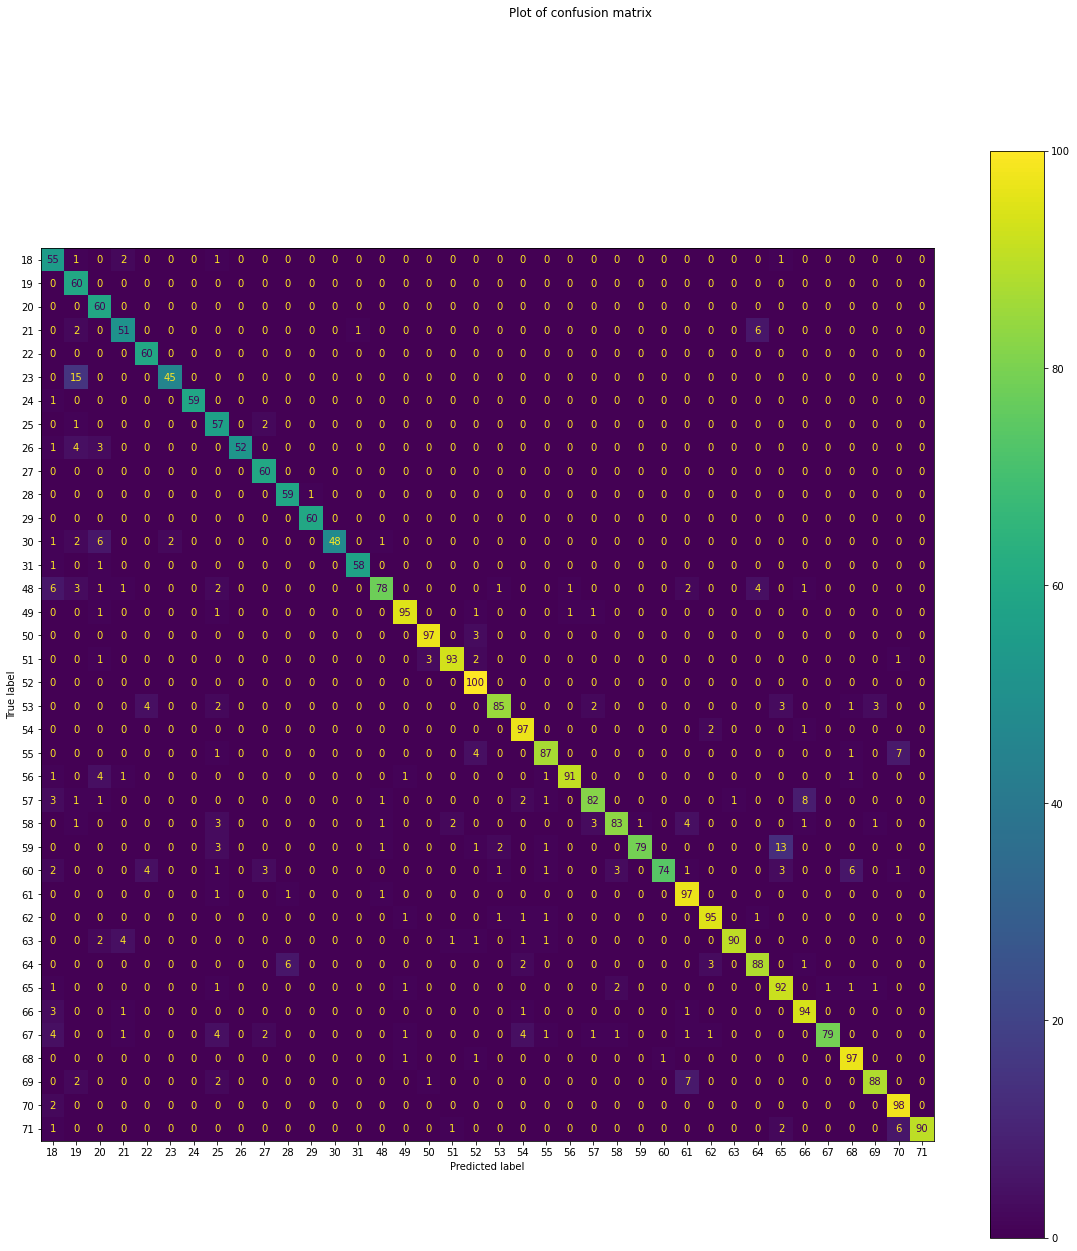

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')